Author: Emily Wong \
January 22, 2023

# Resources

https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-for-ensemble-models/#4

https://towardsdatascience.com/having-an-imbalanced-dataset-here-is-how-you-can-solve-it-1640568947eb

https://neptune.ai/blog/cross-validation-mistakes

# 1. Import libraries, methods, and data

## 1.1. Libraries

In [1]:
#! pip list

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Data wrangling
import pandas as pd
import numpy as np
from numpy.random import uniform, normal, seed

# Machine learning
import sklearn
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, roc_auc_score, balanced_accuracy_score
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold, RandomizedSearchCV, GridSearchCV, train_test_split
import scipy
from scipy.stats import randint
import xgboost as xgb
from imblearn.over_sampling import SMOTENC, RandomOverSampler, SMOTE
from imblearn.under_sampling import TomekLinks, NeighbourhoodCleaningRule, EditedNearestNeighbours, RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
import matplotlib.pyplot as plt

# for nested dictionary
import collections
def makehash():
    return collections.defaultdict(makehash)

# TPOT2
#from dask.distributed import Client, LocalCluster
#import tpot2

# Fairness
import aif360
#import fairlearn
#from fairlearn.metrics import demographic_parity_difference, demographic_parity_ratio, equalized_odds_difference, equalized_odds_ratio, false_negative_rate

The __demographic parity difference__ of 0 means that all groups have the same selection rate. For multiple groups, average across all pairwise differences. Ranges between 0 and 1.

The __demographic parity ratio__ of 1 means that all groups have the same selection rate.

The __equalized odds difference__ of 0 means that all groups have the same true positive, true negative, false positive, and false negative rates.

The __equalized odds ratio__ of 1 means that all groups have the same true positive, true negative, false positive, and false negative rates.

## 1.2 Reweighing Method

In [6]:
def calc_weights2(df, sens_features_name, outcome_name):
    ''' Calculate sample weights according to calculationg given in 
           F. Kamiran and T. Calders,  "Data Preprocessing Techniques for
           Classification without Discrimination," Knowledge and Information
           Systems, 2012.
    ''' 
    
    # combination of label and groups (outputs a table)
    sens_features = df[sens_features_name]
    outcome = df[outcome_name]
    tab = pd.DataFrame(pd.crosstab(index=sens_features, columns=outcome))

    # reweighing weights
    w = makehash()
    n = len(df)
    for r in tab.index:
        key1 = str(r)
        row_sum = tab.loc[r].sum(axis=0)
        for c in tab.columns:
            key2 = str(c)
            col_sum = tab[c].sum()
            if tab.loc[r,c] == 0:
                n_combo = 1
            else:
                n_combo = tab.loc[r,c]
            val = (row_sum*col_sum)/(n*n_combo)
            w[key1][key2] = val
    
    # Instance weights
    instance_weights = []
    for index, row in df.iterrows():
        race = row[sens_features_name]
        out = row[outcome_name]
        instance_weights.append(w[race][str(out)])

    return instance_weights

In [7]:
def display_performance(X_train, y_train, X_test, y_test, model):
    # Train performance
    y_train_pred = model.predict(X_train)
    print("Train Accuracy:", np.round(accuracy_score(y_train, y_train_pred),5))
    print("Train Balanced Acc:",np.round(sklearn.metrics.balanced_accuracy_score(y_train, y_train_pred),5))
    print("Train AUC:",np.round(sklearn.metrics.roc_auc_score(y_train, y_train_pred),5))
    print("Train F1:",np.round(sklearn.metrics.f1_score(y_train, y_train_pred),5))
    cm = confusion_matrix(y_train, y_train_pred)
    print("Train Confusion Matrix:")
    print(cm)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=plt.cm.Greens);

    print("")

    # Test performance
    y_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    print("Test Accuracy:", np.round(test_accuracy,5))
    print("Test Balanced Acc:",np.round(sklearn.metrics.balanced_accuracy_score(y_test, y_pred),5))
    print("Test AUC:",np.round(sklearn.metrics.roc_auc_score(y_test, y_pred),5))
    print("Test F1:",np.round(sklearn.metrics.f1_score(y_test, y_pred),5))
    cm = confusion_matrix(y_test, y_pred)
    print("Test Confusion Matrix:")
    print(cm)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=plt.cm.Greens);

    print("")

    # Find optimal threshold
    step_factor = 0.05 
    threshold_value = 0.05
    roc_score=0
    predicted_proba = model.predict_proba(X_test) #probability of prediction
    while threshold_value <=0.8: #continue to check best threshold upto probability 0.8
        temp_thresh = threshold_value
        predicted = (predicted_proba [:,1] >= temp_thresh).astype('int') #change the class boundary for prediction
        #print('Threshold',temp_thresh,'--',roc_auc_score(y_test, predicted))
        if roc_score<roc_auc_score(y_test, predicted): #store the threshold for best classification
            roc_score = roc_auc_score(y_test, predicted)
            thrsh_score = threshold_value
        threshold_value = threshold_value + step_factor
    print('---Optimum Threshold ---',np.round(thrsh_score,5),'--ROC--',np.round(roc_score,5))

    optim_thresh = thrsh_score
    y_pred_optim = (predicted_proba [:,1] >= optim_thresh).astype('int')
    print("Optimal Test Accuracy:",np.round(accuracy_score(y_test, y_pred_optim),5))
    print("Optimal Test Balanced Accuracy:",np.round(balanced_accuracy_score(y_test, y_pred_optim),5))
    print("Optimal Test AUC:",np.round(sklearn.metrics.roc_auc_score(y_test, y_pred_optim),5))

    # Create the confusion matrix
    cm = confusion_matrix(y_test, y_pred_optim)
    print("Test Confusion Matrix w/ Optimal Threshold:")
    print(cm)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=plt.cm.Greens);

    print("")

    print("Equalized odds difference w/ Optimal Threshold:",np.round(equalized_odds_difference(y_test, y_pred_optim,sensitive_features=race_feature),2))
    
    # Fairness metrics
    print("Equalized odds difference:",np.round(equalized_odds_difference(y_test, y_pred,sensitive_features=race_feature),2))

## 1.3. Data

### 1.3.1. De-Identified EHR

In [11]:
outcome = 'PMAD_mod_high'
data1 = pd.read_excel("Eynav cleaned data 5.xlsx")
print(data1.columns)
print(data1.head(10))
data1 = data1[['FINANCIAL_CLASS','MOM_AGE','MOM_RACE','ETHNIC_GROUP',
             'CHILD_BIRTH_WT','CHILD_GESTATIONAL_AGE',
             'DELIVERY_METHOD','NICU_ADMIT','MFCU_ADMIT',
             'GRAVIDITY','PARITY','ABORTIONS',
             'PREE','GDM','GHTN',
             'MOM_BMI','MOM_LOS','CHILD_LOS',
             #'HIST_ANXIETY','HIST_DEPRESS','HIST_BIPOLAR','HIST_OTHER','MED',
             'MENTAL_HX',
             outcome,]]

Index(['DELIVERY_TIME', 'MOM_PAT_ID', 'FINANCIAL_CLASS', 'PRIMARY_PAYOR_NAME',
       'MARITAL_STATUS', 'ZIP', 'MOM_AGE', 'MOM_RACE', 'ETHNIC_GROUP',
       'CHILD_BIRTH_WT', 'LBW', 'CHILD_GESTATION_AGE_NUMBER', 'PTB',
       'DELIVERY_METHOD', 'NOTE_SW', 'NICU_ADMIT', 'MFCU_ADMIT', 'GRAVIDITY',
       'PARITY', 'ABORTIONS', 'PREE', 'GDM', 'GHTN', 'MOM_BMI', 'MOM_LOS',
       'CHILD_LOS', 'HISTORIC_DX_LIST', 'MED_PSYCH', 'MED_CARDIO', 'ANSWER11',
       'PHQ9_VALUE', 'EPDSANSWER10', 'TOTAL_EPDS_VALUE',
       'MENTAL_HEALTH_DX_CUTOFF', 'HIST_ANXIETY', 'HIST_DEPRESS',
       'HIST_BIPOLAR', 'HIST_PMAD', 'EPDS_risk', 'EPDS_risk2', 'PHQ9_risk',
       'PHQ9_risk2', 'PMAD_risk'],
      dtype='object')
    DELIVERY_TIME  MOM_PAT_ID  FINANCIAL_CLASS          PRIMARY_PAYOR_NAME  \
0  06/23/21 04:22         1.0              0.0                 BLUE SHIELD   
1  12/16/21 08:22         2.0              0.0                 BLUE SHIELD   
2  11/06/23 12:22         3.0              0.0             

KeyError: "['CHILD_GESTATIONAL_AGE', 'MENTAL_HX', 'PMAD_mod_high'] not in index"

In [9]:
outcome = 'PMAD_mod_high'
data = pd.read_excel("De-identified PMAD data.xlsx")
print(data.columns)
print(data.head(10))
data = data[['FINANCIAL_CLASS','MOM_AGE','MOM_RACE','ETHNIC_GROUP',
             'CHILD_BIRTH_WT','CHILD_GESTATIONAL_AGE',
             'DELIVERY_METHOD','NICU_ADMIT','MFCU_ADMIT',
             'GRAVIDITY','PARITY','ABORTIONS',
             'PREE','GDM','GHTN',
             'MOM_BMI','MOM_LOS','CHILD_LOS',
             #'HIST_ANXIETY','HIST_DEPRESS','HIST_BIPOLAR','HIST_OTHER','MED',
             'MENTAL_HX',
             outcome,]]

Index(['DELIVERY_YEAR', 'MOM_PAT_ID', 'FINANCIAL_CLASS', 'PRIMARY_PAYOR_NAME',
       'MARITAL_STATUS', 'MOM_AGE', 'MOM_RACE', 'ETHNIC_GROUP',
       'CHILD_BIRTH_WT', 'LBW', 'CHILD_GESTATION_AGE_NUMBER', 'PTB',
       'DELIVERY_METHOD', 'NOTE_SW', 'NICU_ADMIT', 'MFCU_ADMIT', 'GRAVIDITY',
       'PARITY', 'ABORTIONS', 'PREE', 'GDM', 'GHTN', 'MOM_BMI', 'MOM_LOS',
       'CHILD_LOS', 'HISTORIC_DX_LIST', 'MED_PSYCH', 'MED_CARDIO',
       'PHQ9QUESTION1', 'PHQ9ANSWER1', 'PHQ9QUESTION2', 'PHQ9ANSWER2',
       'PHQ9QUESTION3', 'PHQ9ANSWER3', 'PHQ9QUESTION4', 'PHQ9ANSWER4',
       'PHQ9QUESTION5', 'PHQ9ANSWER5', 'PHQ9QUESTION6', 'PHQ9ANSWER6',
       'PHQ9QUESTION7', 'PHQ9ANSWER7', 'PHQ9QUESTION8', 'PHQ9ANSWER8',
       'PHQ9QUESTION9', 'PHQ9ANSWER9', 'PHQ9_VALUE', 'PHQ9_COMPLETION_YEAR',
       'EPDSQUESTION1', 'EPDSANSWER1', 'EPDSQUESTION2', 'EPDSANSWER2',
       'EPDSQUESTION3', 'EPDSANSWER3', 'EPDSQUESTION4', 'EPDSANSWER4',
       'EPDSQUESTION5', 'EPDSANSWER5', 'EPDSQUESTION6', 'EPDSANSW

KeyError: "['CHILD_GESTATIONAL_AGE', 'MENTAL_HX', 'PMAD_mod_high'] not in index"

In [6]:
#data = pd.read_excel("cleaned data.xlsx")
#data = data[['pmad','ethnic_group','race','marital_status','age_at_delivery',
#             'veteran_status','interpreter_required_yn','zip','insurance',
#             'hist_mad','hist_preterm','preterm','csection']]

### 1.3.2. Eynav Data

In [7]:
outcome = 'PMAD_mod_high'

# Comment: Did you combine ['HIST_ANXIETY','HIST_DEPRESS','HIST_BIPOLAR','HIST_OTHER','MED',] into 'MENTAL_HX'?
# Changed PMAD as the target variable to 'PMAD_mod_high'
# Removed 'MEASURE'

data = pd.read_excel("Eynav cleaned data 3.xlsx")
data = data[['FINANCIAL_CLASS','MOM_AGE','MOM_RACE','ETHNIC_GROUP',
             'CHILD_BIRTH_WT','CHILD_GESTATIONAL_AGE',
             'DELIVERY_METHOD','NICU_ADMIT','MFCU_ADMIT',
             'GRAVIDITY','PARITY','ABORTIONS',
             'PREE','GDM','GHTN',
             'MOM_BMI','MOM_LOS','CHILD_LOS',
             #'HIST_ANXIETY','HIST_DEPRESS','HIST_BIPOLAR','HIST_OTHER','MED',
             'MENTAL_HX',
             outcome,]]

In [8]:
race = data['MOM_RACE']
out = data[outcome]

tab = pd.DataFrame(pd.crosstab(index=race, columns=out, normalize='index'))
print(tab)

np.mean(data[[outcome]])

PMAD_mod_high                                            0.0       1.0
MOM_RACE                                                              
Asian or Native Hawaiian or Other Pacific Islander  0.886127  0.113873
Black or African American                           0.903710  0.096290
Multiracial                                         0.915280  0.084720
Other                                               0.914732  0.085268
Unknown                                             0.793651  0.206349
White                                               0.930722  0.069278


0.08074872129720317

## 1.3.3. Curate Data

In [9]:
data = data.dropna()            # keep only complete data (for now)
data = data.sample(len(data))   # randomly shuffle rows

1849 317


<BarContainer object of 2 artists>

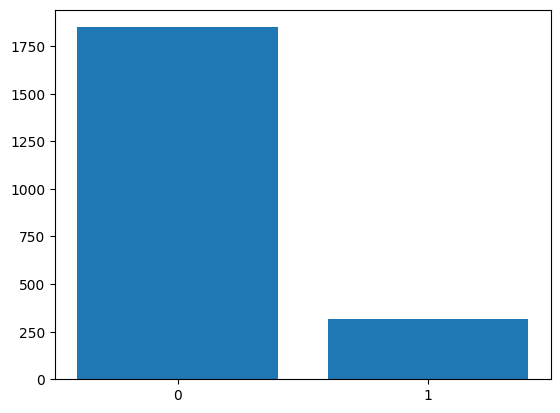

In [10]:
count0, count1 = data[outcome].value_counts()
print(count0, count1)

x = ['0','1']
y = [count0, count1]
plt.bar(x, y)

## 1.3.4. Weight Data

In [14]:
def calc_weights(X, y, sens_features, privileged_groups, unprivileged_groups):
    ''' Calculate sample weights according to calculationg given in 
           F. Kamiran and T. Calders,  "Data Preprocessing Techniques for
           Classification without Discrimination," Knowledge and Information
           Systems, 2012.
    ''' 
    (k, v_p), = privileged_groups[0].items()
    (k, v_up), = unprivileged_groups[0].items()

    priv_cond = X[sens_features] == v_p
    priv_cond = priv_cond.to_numpy().flatten()
    unpriv_cond = X[sens_features] == v_up
    unpriv_cond = unpriv_cond.to_numpy().flatten()
    fav_cond = y==1
    unfav_cond = y==0

    # combination of label and privileged/unpriv. groups
    cond_p_fav = np.logical_and(fav_cond, priv_cond)
    cond_p_unfav = np.logical_and(unfav_cond, priv_cond)
    cond_up_fav = np.logical_and(fav_cond, unpriv_cond)
    cond_up_unfav = np.logical_and(unfav_cond, unpriv_cond)

    instance_weights = np.ones(X.shape[0])
    n = X.shape[0]
    n_p = np.sum(instance_weights[priv_cond], dtype=np.float64)
    n_up = np.sum(instance_weights[unpriv_cond], dtype=np.float64)
    n_fav = np.sum(instance_weights[fav_cond], dtype=np.float64)
    n_unfav = np.sum(instance_weights[unfav_cond], dtype=np.float64)

    n_p_fav = np.sum(instance_weights[cond_p_fav], dtype=np.float64)
    n_p_unfav = np.sum(instance_weights[cond_p_unfav],dtype=np.float64)
    n_up_fav = np.sum(instance_weights[cond_up_fav],dtype=np.float64)
    n_up_unfav = np.sum(instance_weights[cond_up_unfav],dtype=np.float64)

    # reweighing weights
    w_p_fav = n_fav*n_p / (n*n_p_fav)
    w_p_unfav = n_unfav*n_p / (n*n_p_unfav)
    w_up_fav = n_fav*n_up / (n*n_up_fav)
    w_up_unfav = n_unfav*n_up / (n*n_up_unfav)

    instance_weights[cond_p_fav] *= w_p_fav
    instance_weights[cond_p_unfav] *= w_p_unfav
    instance_weights[cond_up_fav] *= w_up_fav
    instance_weights[cond_up_unfav] *= w_up_unfav

    return instance_weights


In [16]:
# Emily's version
data['w'] = calc_weights2(df=data, sens_features_name="MOM_RACE", outcome_name=outcome)
print(data['w'])

# Anil's version
privileged_groups = [{'MOM_RACE': 1}]
unprivileged_groups = [{'MOM_RACE': 0}]
sample_weight = calc_weights(data.drop(outcome, axis=1), data[outcome], sens_features=['MOM_RACE'], privileged_groups=privileged_groups, unprivileged_groups=unprivileged_groups)
print(sample_weight)


#pd.DataFrame(pd.crosstab(index=data['w'], columns=data['PMAD']))
#pd.DataFrame(pd.crosstab(index=data['w'], columns=data['MOM_RACE']))

5790     0.944461
8517     0.991748
4221     0.991748
1314     0.944461
6105     0.944461
           ...   
7016     0.991748
1225     1.021972
9846     0.991748
11212    0.976662
182      0.976662
Name: w, Length: 2166, dtype: float64
[1. 1. 1. ... 1. 1. 1.]


## 1.3.5. Get Dummies and Split

In [17]:
# get dummy variables
data = pd.get_dummies(data)

In [18]:
data['MOM_AGE'] = data['MOM_AGE'].astype('int64')
data['GRAVIDITY'] = data['GRAVIDITY'].astype('int64')
data['PARITY'] = data['PARITY'].astype('int64')
data['ABORTIONS'] = data['ABORTIONS'].astype('int64')

data['MOM_BMI'] = data['MOM_BMI'].astype('float')
data['CHILD_BIRTH_WT'] = data['CHILD_BIRTH_WT'].astype('float')
data['CHILD_GESTATIONAL_AGE'] = data['CHILD_GESTATIONAL_AGE'].astype('float')
data['MOM_LOS'] = data['MOM_LOS'].astype('float')
data['CHILD_LOS'] = data['CHILD_LOS'].astype('float')

data[outcome] = data[outcome].astype('int64')
data['HIST_ANXIETY'] = data['HIST_ANXIETY'].astype('int64')
data['HIST_DEPRESS'] = data['HIST_DEPRESS'].astype('int64')
data['HIST_BIPOLAR'] = data['HIST_BIPOLAR'].astype('int64')
data['HIST_OTHER'] = data['HIST_OTHER'].astype('int64')
data['MED'] = data['MED'].astype('int64')
data['FINANCIAL_CLASS'] = data['FINANCIAL_CLASS'].astype('int64')
data['NICU_ADMIT'] = data['NICU_ADMIT'].astype('int64')
data['MFCU_ADMIT'] = data['MFCU_ADMIT'].astype('int64')
data['PREE'] = data['PREE'].astype('int64')
data['GDM'] = data['GDM'].astype('int64')
data['GHTN'] = data['GHTN'].astype('int64')
#data['MENTAL_HX'] = data['MENTAL_HX'].astype('int64')
data['MOM_RACE_Asian or Native Hawaiian or Other Pacific Islander'] = data['MOM_RACE_Asian or Native Hawaiian or Other Pacific Islander'].astype('int64')
data['MOM_RACE_Black or African American'] = data['MOM_RACE_Black or African American'].astype('int64')
data['MOM_RACE_Multiracial'] = data['MOM_RACE_Multiracial'].astype('int64')
data['MOM_RACE_Other'] = data['MOM_RACE_Other'].astype('int64')
data['MOM_RACE_Unknown'] = data['MOM_RACE_Unknown'].astype('int64')
data['MOM_RACE_White'] = data['MOM_RACE_White'].astype('int64')
data['ETHNIC_GROUP_Hispanic'] = data['ETHNIC_GROUP_Hispanic'].astype('int64')
data['ETHNIC_GROUP_Non-Hispanic'] = data['ETHNIC_GROUP_Non-Hispanic'].astype('int64')
data['ETHNIC_GROUP_Unknown'] = data['ETHNIC_GROUP_Unknown'].astype('int64')
data['DELIVERY_METHOD_Cesarean'] = data['DELIVERY_METHOD_Cesarean'].astype('int64')
data['DELIVERY_METHOD_Vaginal'] = data['DELIVERY_METHOD_Vaginal'].astype('int64')
data['MEASURE_EPDS'] = data['MEASURE_EPDS'].astype('int64')
data['MEASURE_PHQ9'] = data['MEASURE_PHQ9'].astype('int64')

data = data.drop(['DELIVERY_METHOD_Vaginal','MEASURE_PHQ9'], axis=1)

KeyError: 'HIST_ANXIETY'

Split data. Can specify whether to use stratify sampling or not.

In [12]:
# split into X and y
X = data.drop([outcome], axis=1)
y = data[[outcome]]

# Split the data into training and test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25, shuffle=True, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25, shuffle=True, stratify=y, random_state=42)
X_test = X_test.drop(['w'], axis=1)

# Sensitive features
race_feature = X_test[['MOM_RACE_Asian or Native Hawaiian or Other Pacific Islander',
                       'MOM_RACE_Black or African American',
                       'MOM_RACE_Multiracial',
                       'MOM_RACE_Other',
                       'MOM_RACE_Unknown',
                       'MOM_RACE_White']]

In [13]:
cat_features = ['FINANCIAL_CLASS','NICU_ADMIT','MFCU_ADMIT','PREE','GHTN',
                'HIST_ANXIETY','HIST_DEPRESS','HIST_BIPOLAR','HIST_OTHER','MED',
                'MOM_RACE_Asian or Native Hawaiian or Other Pacific Islander',
                'MOM_RACE_Black or African American','MOM_RACE_Multiracial','MOM_RACE_Other','MOM_RACE_Unknown','MOM_RACE_White',
                'ETHNIC_GROUP_Hispanic','ETHNIC_GROUP_Non-Hispanic','ETHNIC_GROUP_Unknown','DELIVERY_METHOD_Cesarean','MEASURE_EPDS']

In [14]:
count0_train, count1_train = y_train.value_counts()
print(count0_train, count1_train)

count0_test, count1_test = y_test.value_counts()
print(count0_test, count1_test)

5754 501
1919 167


# 2. Handle imbalanced data

## 2.1. Simple Over Sampling Minority (PMAD)

In [15]:
ros = RandomOverSampler(sampling_strategy = "auto",random_state=0)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
weights_ros = X_train_ros['w']
X_train_ros = X_train_ros.drop(['w'], axis=1)
y_train_ros.value_counts()

PMAD
0       5754
1       5754
Name: count, dtype: int64

## 2.2. Synthetic Over-Sampling Technique, NC

SMOTE-NC for dataset containing numerical and categorical features. However, it is not designed to work with only categorical features.

In [16]:
smt = SMOTENC(categorical_features = cat_features, sampling_strategy = 15/85,random_state=0)
X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train)
y_train_smt.value_counts()
weights_smt = X_train_smt['w']
X_train_smt = X_train_smt.drop(['w'], axis=1)
y_train_smt.value_counts()

PMAD
0       5754
1       1015
Name: count, dtype: int64

## 2.3. Simple Under Sampling Majority (PMAD)

In [17]:
rus = RandomUnderSampler(sampling_strategy = "auto", random_state=0)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
weights_rus = X_train_rus['w']
X_train_rus = X_train_rus.drop(['w'], axis=1)
y_train_rus.value_counts()

PMAD
0       501
1       501
Name: count, dtype: int64

In [ ]:
# without imblearn package

train_data = pd.concat([X_train,y_train],axis=1)

# class count
healthy_count, pmad_count = train_data['PMAD'].value_counts()
healthy_count, pmad_count

# Separate classes
healthy = train_data[train_data['PMAD'] == 0]
pmad = train_data[train_data['PMAD'] == 1]

seed(0)
healthy_under = healthy.sample(pmad_count, replace=False)
train_data_under = pd.concat([healthy_under,pmad], axis =0)
print(train_data_under.shape)

# then split back into X_train and y_train
X_train_rus2 = train_data_under.drop('PMAD', axis=1)
y_train_rus2 = train_data_under[['PMAD']]
y_train_rus2.value_counts()

## 2.4. Edited Nearest Neighbours to Remove Noisy Majority (PMAD)

In [18]:
enn = EditedNearestNeighbours()
X_train_enn, y_train_enn = rus.fit_resample(X_train, y_train)
weights_enn = X_train_enn['w']
X_train_enn = X_train_enn.drop(['w'], axis=1)
y_train_enn.value_counts()

PMAD
0       501
1       501
Name: count, dtype: int64

## 2.5. SMOTE + ENN

In [19]:
smt_enn = SMOTEENN(smote = SMOTE(sampling_strategy = 15/85), enn = EditedNearestNeighbours())
X_train_smt_enn, y_train_smt_enn = smt_enn.fit_resample(X_train, y_train)
weights_smt_enn = X_train_smt_enn['w']
X_train_smt_enn = X_train_smt_enn.drop(['w'], axis=1)
y_train_smt_enn.value_counts()

PMAD
0       4142
1       1015
Name: count, dtype: int64

# 3. Modeling

## 3.1. Ensemble Classifers

In [20]:
# Extract weights and drop from training and test data frames
weights = X_train['w']
X_train = X_train.drop(['w'], axis=1)

### Finetune balanced ensemble classifer manually.

Ensemble best hyperparameters: {'sampling_strategy': 'auto', 'n_estimators': 11, 'max_features': 0.9441475158124409, 'base_estimator': RandomForestClassifier()} \
XGB  best hyperparameters (old): {'subsample': 0.5, 'n_estimators': 101, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.3} \
XGB  best hyperparameters: {'subsample': 0.5, 'n_estimators': 136, 'learning_rate': 0.1, 'lambda': 25, 'gamma': 0.1, 'colsample_bytree': 0.3, 'alpha': 10}

Train Accuracy: 0.71657
Train Balanced Acc: 0.71657
Train AUC: 0.71657
Train F1: 0.7264
Train Confusion Matrix:
[[341 160]
 [124 377]]

Test Accuracy: 0.64238
Test Balanced Acc: 0.66075
Test AUC: 0.66075
Test F1: 0.23409
Test Confusion Matrix:
[[1226  693]
 [  53  114]]

---Optimum Threshold --- 0.55 --ROC-- 0.66613
Optimal Test Accuracy: 0.72771
Optimal Test Balanced Accuracy: 0.66613
Optimal Test AUC: 0.66613
Test Confusion Matrix w/ Optimal Threshold:
[[1419  500]
 [  68   99]]

Equalized odds difference w/ Optimal Threshold: 0.82
Equalized odds difference: 0.89


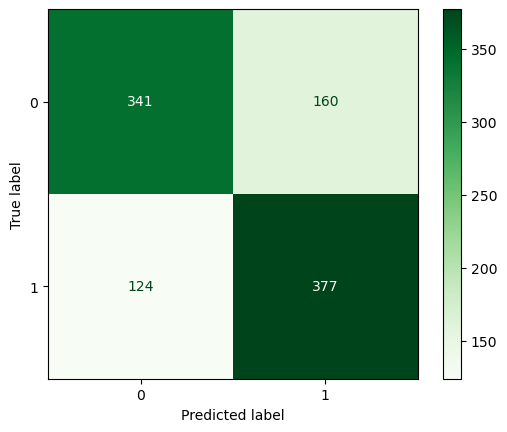

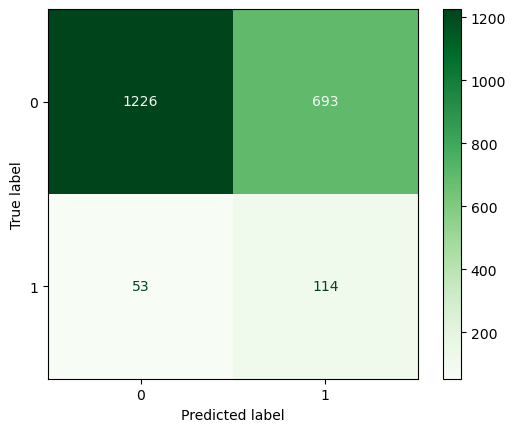

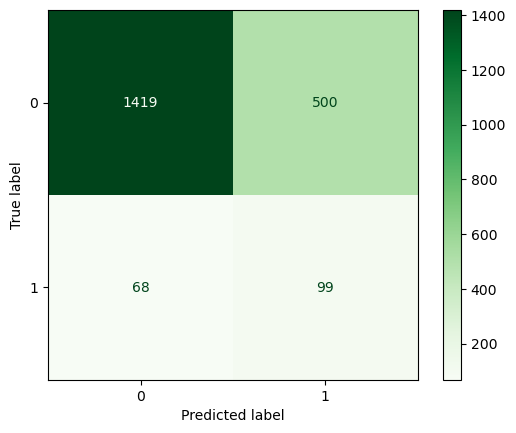

In [28]:
x = X_train_rus
y = y_train_rus.values.ravel()
w = weights_rus

bbc = BalancedBaggingClassifier(random_state=0, 
                                base_estimator=xgb.XGBClassifier(objective="binary:logistic", random_state=0, subsample = 0.5, n_estimators=136, learning_rate = 0.1, gamma=0.1, colsample_bytree = 0.3, alpha=10), 
                                sampling_strategy='majority', 
                                sampler=RandomUnderSampler(),
                                n_estimators=11, 
                                max_features=0.944)

# Fit the grid search object to the data
bbc.fit(x, y)

display_performance(X_train=x, y_train=y, X_test=X_test, y_test=y_test, model=bbc)

### Finetune balanced ensemble classifer through randomized search.

In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. The number of parameter settings that are tried is given by **n_iter**.

In [22]:
x = X_train_rus
y = y_train_rus.values.ravel()
w = weights_rus


bbc = BalancedBaggingClassifier(random_state=0, sampling_strategy='auto')
parameter_space = {'base_estimator': [RandomForestClassifier(),DecisionTreeClassifier(),GradientBoostingClassifier(),svm.SVC()],
                   'max_features': [0.9,0.95,0.96,0.97,0.98,0.99,1.0],
                   'n_estimators': list(range(5,15+1)) # 5 to 15
                  }

# Use random search to find the best hyperparameters
rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=0)
rand_search = RandomizedSearchCV(bbc, 
                                 param_distributions = parameter_space, 
                                 scoring = ['balanced_accuracy','f1','roc_auc'],
                                 refit = 'balanced_accuracy',
                                 n_iter=10, 
                                 cv=rkf,
                                 verbose=1)

# Fit the random search object to the data
rand_search.fit(X_train, y_train.values.ravel())

Fitting 25 folds for each of 10 candidates, totalling 250 fits


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=5, random_state=0),
                   estimator=BalancedBaggingClassifier(random_state=0),
                   param_distributions={'base_estimator': [RandomForestClassifier(),
                                                           DecisionTreeClassifier(),
                                                           GradientBoostingClassifier(),
                                                           SVC()],
                                        'max_features': [0.9, 0.95, 0.96, 0.97,
                                                         0.98, 0.99, 1.0],
                                        'n_estimators': [5, 6, 7, 8, 9, 10, 11,
                                                         12, 13, 14, 15]},
                   refit='balanced_accuracy',
                   scoring=['balanced_accuracy', 'f1', 'roc_auc'], verbose=1)

Ensemble best hyperparameters: {'n_estimators': 13, 'max_features': 0.97, 'base_estimator': GradientBoostingClassifier()}
Train Accuracy: 0.75649
Train Balanced Acc: 0.75649
Train AUC: 0.75649
Train F1: 0.76448
Train Confusion Matrix:
[[362 139]
 [105 396]]

Test Accuracy: 0.7023
Test Balanced Acc: 0.65779
Test AUC: 0.65779
Test F1: 0.24544
Test Confusion Matrix:
[[1364  555]
 [  66  101]]

---Optimum Threshold --- 0.45 --ROC-- 0.6722
Optimal Test Accuracy: 0.6232
Optimal Test Balanced Accuracy: 0.6722
Optimal Test AUC: 0.6722
Test Confusion Matrix w/ Optimal Threshold:
[[1178  741]
 [  45  122]]

Equalized odds difference w/ Optimal Threshold: 0.93
Equalized odds difference: 0.89


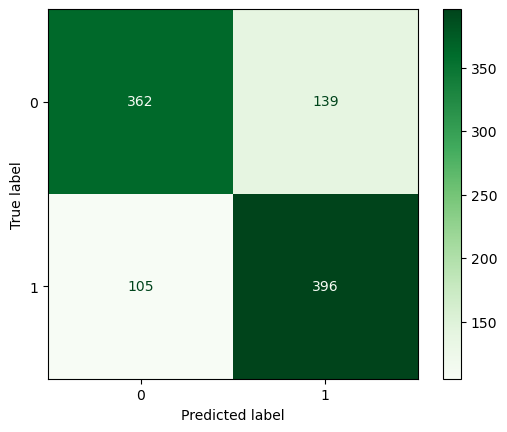

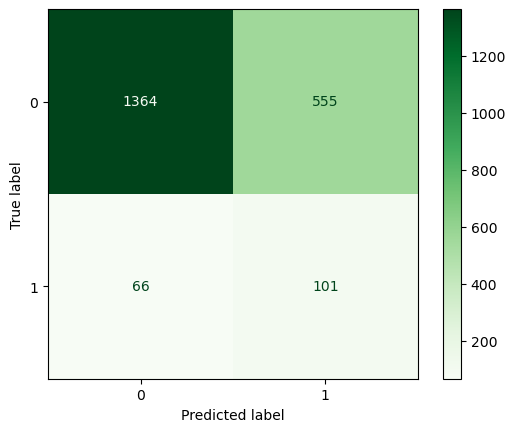

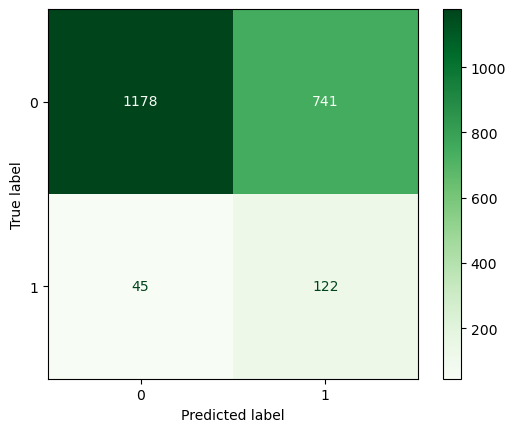

In [23]:
best_bbc = rand_search.best_estimator_
print('Ensemble best hyperparameters:',  rand_search.best_params_)

display_performance(X_train=x, y_train=y, X_test=X_test, y_test=y_test, model=best_bbc)

### Finetune AdaBoost Classifier

https://www.analyticsvidhya.com/blog/2021/09/adaboost-algorithm-a-complete-guide-for-beginners/#h-step-1-assigning-weights

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

In [24]:
x = X_train_rus
y = y_train_rus.values.ravel()
w = weights_rus

abc = AdaBoostClassifier(random_state=0, 
                         algorithm='SAMME.R',
                         base_estimator=xgb.XGBClassifier(objective="binary:logistic", random_state=0, subsample = 0.5, n_estimators=101, learning_rate = 0.01, gamma=0.1, colsample_bytree = 0.3))

parameter_space = {#'estimator': [RandomForestClassifier(),DecisionTreeClassifier(),GradientBoostingClassifier(),svm.SVC()],
                   'n_estimators': list(range(1,20+1)), # 1 to 20
                   'learning_rate': uniform(0.0001,1.0,20)
                  }

# Use random search to find the best hyperparameters
#rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=0)
rand_search = RandomizedSearchCV(abc, 
                                 param_distributions = parameter_space, 
                                 scoring = ['balanced_accuracy','f1','roc_auc'],
                                 refit = 'balanced_accuracy',
                                 n_iter=10, 
                                 cv=5,
                                 verbose=1)

# Fit the random search object to the data
rand_search.fit(x, y, sample_weight=w)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=AdaBoostClassifier(base_estimator=XGBClassifier(base_score=None,
                                                                             booster=None,
                                                                             callbacks=None,
                                                                             colsample_bylevel=None,
                                                                             colsample_bynode=None,
                                                                             colsample_bytree=0.3,
                                                                             device=None,
                                                                             early_stopping_rounds=None,
                                                                             enable_categorical=False,
                                                                             eval_metric=None,
                                                                             feature_types=None,
                                                                             gamma=0.1,
                                                                             grow_policy=None,
                                                                             importance_type=None,
                                                                             interactio...
                   param_distributions={'learning_rate': array([0.09465567, 0.19763719, 0.08159865, 0.97679173, 0.20315011,
       0.63708327, 0.20044307, 0.04307131, 0.50857399, 0.64995337,
       0.80587617, 0.11549481, 0.785346  , 0.28462268, 0.1763439 ,
       0.19478534, 0.03201895, 0.43917346, 0.56863045, 0.58074818]),
                                        'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10, 11, 12, 13, 14,
                                                         15, 16, 17, 18, 19,
                                                         20]},
                   refit='balanced_accuracy',
                   scoring=['balanced_accuracy', 'f1', 'roc_auc'], verbose=1)

Ensemble best hyperparameters: {'n_estimators': 3, 'learning_rate': 0.11549481456215552}
Train Accuracy: 0.5
Train Balanced Acc: 0.5
Train AUC: 0.5
Train F1: 0.66667
Train Confusion Matrix:
[[  0 501]
 [  0 501]]

Test Accuracy: 0.08006
Test Balanced Acc: 0.5
Test AUC: 0.5
Test F1: 0.14825
Test Confusion Matrix:
[[   0 1919]
 [   0  167]]

---Optimum Threshold --- 0.05 --ROC-- 0.5
Optimal Test Accuracy: 0.08006
Optimal Test Balanced Accuracy: 0.5
Optimal Test AUC: 0.5
Test Confusion Matrix w/ Optimal Threshold:
[[   0 1919]
 [   0  167]]

Equalized odds difference w/ Optimal Threshold: 0.0
Equalized odds difference: 0.0


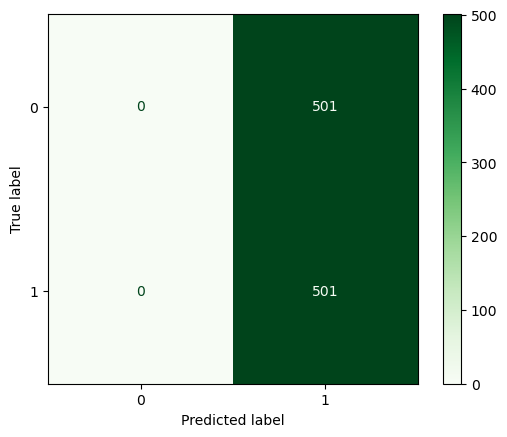

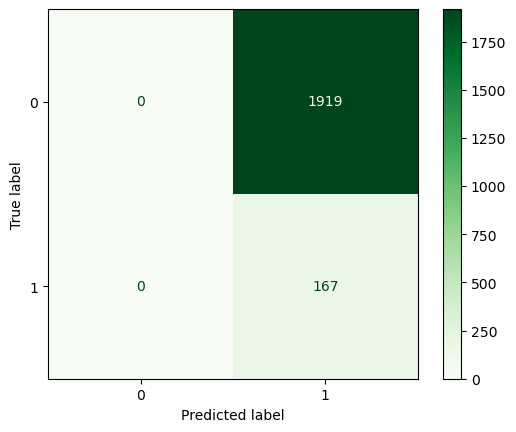

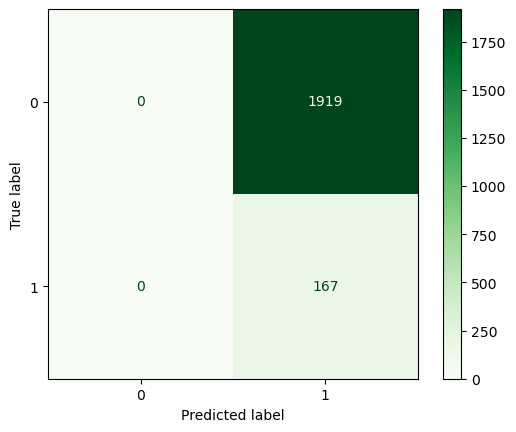

In [25]:
best_abc = rand_search.best_estimator_
print('Ensemble best hyperparameters:', rand_search.best_params_)

display_performance(X_train=x, y_train=y, X_test=X_test, y_test=y_test, model=best_abc)

### Finetune XG Boost Classifier

https://www.kaggle.com/code/stuarthallows/using-xgboost-with-scikit-learn

In [26]:
x = X_train_rus
y = y_train_rus.values.ravel()
w = weights_rus

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=0)

params = {"colsample_bytree": [0.3, 0.4, 0.5, 0.6, 0.7],
          "gamma": [0, 0.1, 0.2, 0.3, 0.4, 0.5],
          "learning_rate": [0.01, 0.05, 0.1, 0.2,  0.3], # default 0.1
          "n_estimators": list(range(100,150+1)), # 100 to 150
          "subsample": [0.4,0.5,0.6],
          "alpha":[0,5,10,25,50,75,100],
          "lambda": [0,5,10,25,50,75,100]
          }

#rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=0)
rand_search = RandomizedSearchCV(xgb_model, 
                                 param_distributions=params, 
                                 random_state=42, 
                                 n_iter=20, 
                                 cv=10, 
                                 verbose=1, 
                                 n_jobs=1, 
                                 return_train_score=True,
                                 scoring = ['balanced_accuracy','f1','roc_auc'],
                                 refit = 'balanced_accuracy')

rand_search.fit(x, y, sample_weight=w)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rat...
                                        'lambda': [0, 5, 10, 25, 50, 75, 100],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2,
                                                          0.3],
                                        'n_estimators': [100, 101, 102, 103,
                                                         104, 105, 106, 107,
                                                         108, 109, 110, 111,
                                                         112, 113, 114, 115,
                                                         116, 117, 118, 119,
                                                         120, 121, 122, 123,
                                                         124, 125, 126, 127,
                                                         128, 129, ...],
                                        'subsample': [0.4, 0.5, 0.6]},
                   random_state=42, refit='balanced_accuracy',
                   return_train_score=True,
                   scoring=['balanced_accuracy', 'f1', 'roc_auc'], verbose=1)

XGB  best hyperparameters: {'subsample': 0.5, 'n_estimators': 136, 'learning_rate': 0.1, 'lambda': 25, 'gamma': 0.1, 'colsample_bytree': 0.3, 'alpha': 10}
Train Accuracy: 0.70659
Train Balanced Acc: 0.70659
Train AUC: 0.70659
Train F1: 0.7112
Train Confusion Matrix:
[[346 155]
 [139 362]]

Test Accuracy: 0.65436
Test Balanced Acc: 0.6782
Test AUC: 0.6782
Test F1: 0.2466
Test Confusion Matrix:
[[1247  672]
 [  49  118]]

---Optimum Threshold --- 0.45 --ROC-- 0.67972
Optimal Test Accuracy: 0.55657
Optimal Test Balanced Accuracy: 0.67972
Optimal Test AUC: 0.67972
Test Confusion Matrix w/ Optimal Threshold:
[[1023  896]
 [  29  138]]

Equalized odds difference w/ Optimal Threshold: 0.93
Equalized odds difference: 0.89


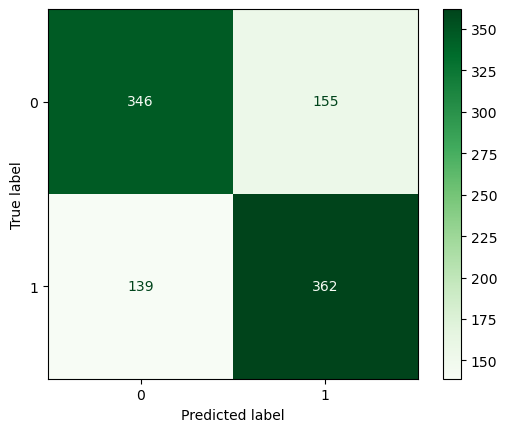

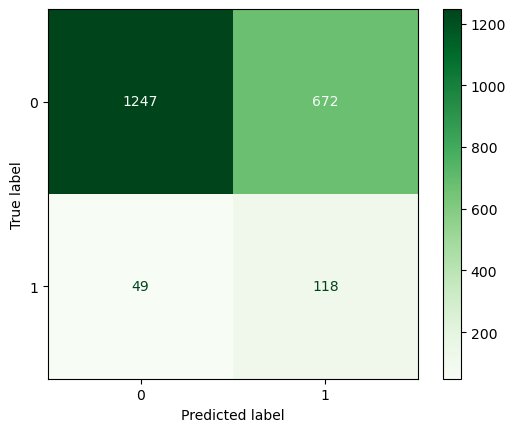

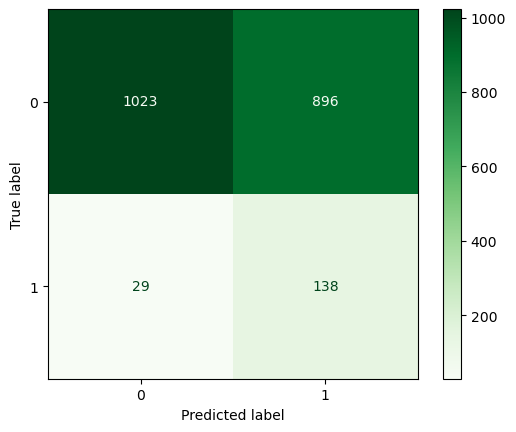

In [27]:
best_xgb = rand_search.best_estimator_
print('XGB  best hyperparameters:',  rand_search.best_params_)

display_performance(X_train=x, y_train=y, X_test=X_test, y_test=y_test, model=best_xgb)

## 3.1. Logistic Regression

In [34]:
x = X_train_rus
y = y_train_rus.values.ravel()
w = weights_rus

glm = LogisticRegression(max_iter=1000, solver='liblinear')

seed(0)
parameter_space = {'class_weight': [{0:1, 1:2},{0:1, 1:3},{0:1, 1:5},{0:1, 1:5},{0:1, 1:6},{0:1, 1:7},{0:1, 1:8},{0:1, 1:9},{0:1, 1:10},
                                    {0:2, 1:2},{0:2, 1:3},{0:2, 1:5},{0:2, 1:5},{0:2, 1:6},{0:2, 1:7},{0:2, 1:8},{0:2, 1:9},{0:2, 1:10},
                                    {0:3, 1:2},{0:3, 1:3},{0:3, 1:5},{0:3, 1:5},{0:3, 1:6},{0:3, 1:7},{0:3, 1:8},{0:3, 1:9},{0:3, 1:10}]
                  }

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(glm, 
                                 param_distributions = parameter_space, 
                                 n_iter=5, 
                                 cv=5,
                                 verbose=1)

# Fit the random search object to the data
rand_search.fit(x, y, sample_weight=w)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(max_iter=1000,
                                                solver='liblinear'),
                   n_iter=5,
                   param_distributions={'class_weight': [{0: 1, 1: 2},
                                                         {0: 1, 1: 3},
                                                         {0: 1, 1: 5},
                                                         {0: 1, 1: 5},
                                                         {0: 1, 1: 6},
                                                         {0: 1, 1: 7},
                                                         {0: 1, 1: 8},
                                                         {0: 1, 1: 9},
                                                         {0: 1, 1: 10},
                                                         {0: 2, 1: 2},
                                                         {0: 2, 1: 3},
                                                         {0: 2, 1: 5},
                                                         {0: 2, 1: 5},
                                                         {0: 2, 1: 6},
                                                         {0: 2, 1: 7},
                                                         {0: 2, 1: 8},
                                                         {0: 2, 1: 9},
                                                         {0: 2, 1: 10},
                                                         {0: 3, 1: 2},
                                                         {0: 3, 1: 3},
                                                         {0: 3, 1: 5},
                                                         {0: 3, 1: 5},
                                                         {0: 3, 1: 6},
                                                         {0: 3, 1: 7},
                                                         {0: 3, 1: 8},
                                                         {0: 3, 1: 9},
                                                         {0: 3, 1: 10}]},
                   verbose=1)

Best GLM hyperparameters: {'class_weight': {0: 3, 1: 8}}
Train Accuracy: 0.58782
Train Balanced Acc: 0.58782
Train AUC: 0.58782
Train F1: 0.69744
Train Confusion Matrix:
[[113 388]
 [ 25 476]]

Test Accuracy: 0.27373
Test Balanced Acc: 0.57793
Test AUC: 0.57793
Test F1: 0.17168
Test Confusion Matrix:
[[ 414 1505]
 [  10  157]]

---Optimum Threshold --- 0.75 --ROC-- 0.67069
Optimal Test Accuracy: 0.73106
Optimal Test Balanced Accuracy: 0.67069
Optimal Test AUC: 0.67069
Test Confusion Matrix w/ Optimal Threshold:
[[1425  494]
 [  67  100]]

Equalized odds difference w/ Optimal Threshold: 0.62
Equalized odds difference: 0.19


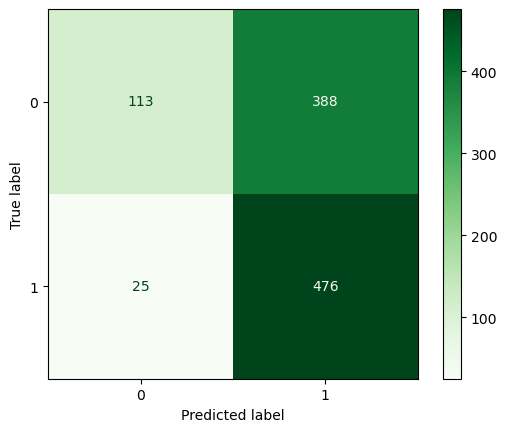

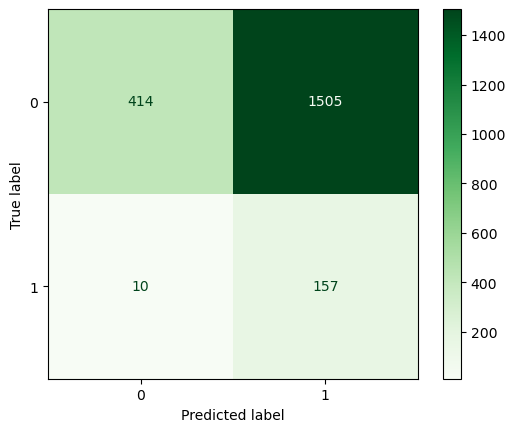

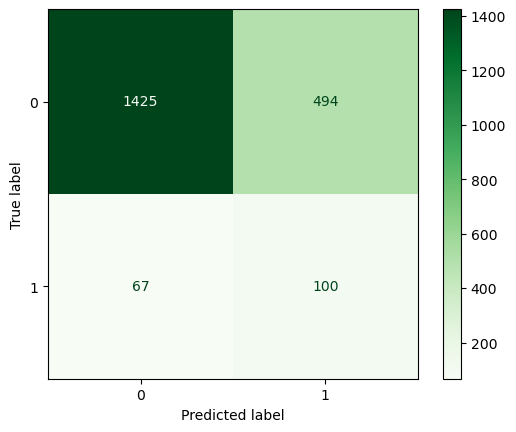

In [35]:
# Print the best hyperparameters
best_glm = rand_search.best_estimator_
print('Best GLM hyperparameters:',  rand_search.best_params_)

display_performance(X_train=x, y_train=y, X_test=X_test, y_test=y_test, model=best_glm)

## 3.2. Random Forest

Best hyperparameters so far: 'max_depth': 1, 'n_estimators': 373 \
Using random under sampling

In [36]:
x = X_train_rus
y = y_train_rus.values.ravel()
w = weights_rus

rf = RandomForestClassifier()

seed(1)
parameter_space = {'n_estimators': np.round(uniform(50,500,20),0).astype('int64'),
                   'max_depth': np.round(uniform(1,20,20),0).astype('int64')
                  }

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = parameter_space, 
                                 n_iter=5, 
                                 cv=5,
                                 verbose=1)

# Fit the random search object to the data
rand_search.fit(x, y, sample_weight=w)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': array([16, 19,  7, 14, 18, 18,  3,  2,  4, 18,  3,  9, 19, 11, 14,  7, 14,
       17,  1, 15]),
                                        'n_estimators': array([238, 374,  50, 186, 116,  92, 134, 206, 229, 292, 239, 358, 142,
       445,  62, 352, 238, 301, 113, 139])},
                   verbose=1)

RF Best hyperparameters: {'n_estimators': 445, 'max_depth': 3}
Train Accuracy: 0.70659
Train Balanced Acc: 0.70659
Train AUC: 0.70659
Train F1: 0.71176
Train Confusion Matrix:
[[345 156]
 [138 363]]

Test Accuracy: 0.66107
Test Balanced Acc: 0.66545
Test AUC: 0.66545
Test F1: 0.2406
Test Confusion Matrix:
[[1267  652]
 [  55  112]]

---Optimum Threshold --- 0.5 --ROC-- 0.66545
Optimal Test Accuracy: 0.66107
Optimal Test Balanced Accuracy: 0.66545
Optimal Test AUC: 0.66545
Test Confusion Matrix w/ Optimal Threshold:
[[1267  652]
 [  55  112]]

Equalized odds difference w/ Optimal Threshold: 0.86
Equalized odds difference: 0.86


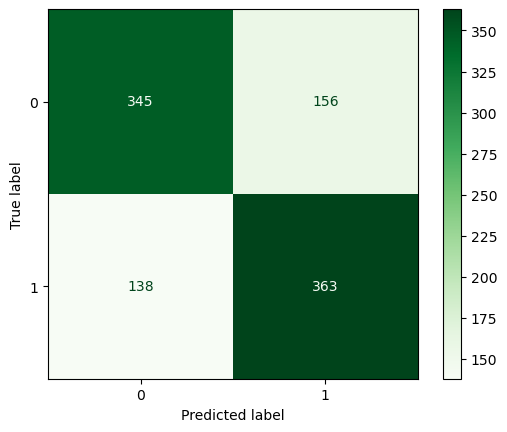

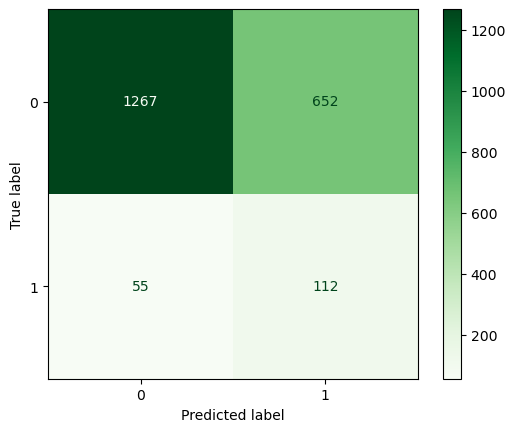

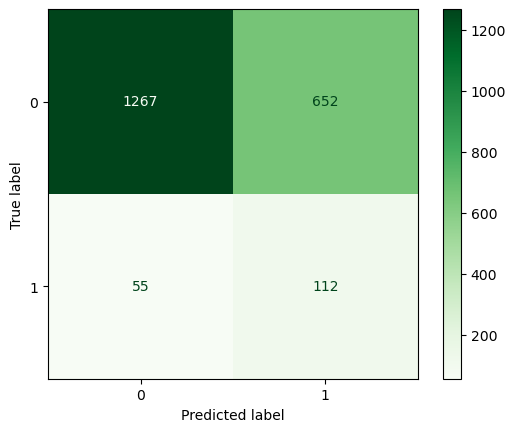

In [37]:
best_rf = rand_search.best_estimator_
print('RF Best hyperparameters:',  rand_search.best_params_)

display_performance(X_train=x, y_train=y, X_test=X_test, y_test=y_test, model=best_rf)

In [41]:
races = ['MOM_RACE_Asian or Native Hawaiian or Other Pacific Islander',
         'MOM_RACE_Black or African American',
         'MOM_RACE_Multiracial',
         'MOM_RACE_Other',
         'MOM_RACE_Unknown',
         'MOM_RACE_White']

optim_thresh = 0.5
y_pred_optim = (best_rf.predict_proba(X_test)[:,1] >= optim_thresh).astype('int')
for r in races:
    feature = X_test[[r]]
    measure = np.round(equalized_odds_difference(y_test, y_pred_optim, sensitive_features=feature),5)
    print("Equalized odds difference:",r,":",measure)

Equalized odds difference: MOM_RACE_Asian or Native Hawaiian or Other Pacific Islander : 0.22405
Equalized odds difference: MOM_RACE_Black or African American : 0.11675
Equalized odds difference: MOM_RACE_Multiracial : 0.67879
Equalized odds difference: MOM_RACE_Other : 0.14336
Equalized odds difference: MOM_RACE_Unknown : 0.6747
Equalized odds difference: MOM_RACE_White : 0.09971


MOM_RACE_Asian or Native Hawaiian or Other Pacific Islander : 14.29 % miss rate
MOM_RACE_Asian or Native Hawaiian or Other Pacific Islander : 85.71 % hit rate
MOM_RACE_Black or African American : 23.08 % miss rate
MOM_RACE_Black or African American : 76.92 % hit rate
MOM_RACE_Multiracial : 100.0 % miss rate
MOM_RACE_Multiracial : 0.0 % hit rate
MOM_RACE_Other : 46.15 % miss rate
MOM_RACE_Other : 53.85 % hit rate
MOM_RACE_Unknown : 100.0 % miss rate
MOM_RACE_Unknown : 0.0 % hit rate
MOM_RACE_White : 37.11 % miss rate
MOM_RACE_White : 62.89 % hit rate


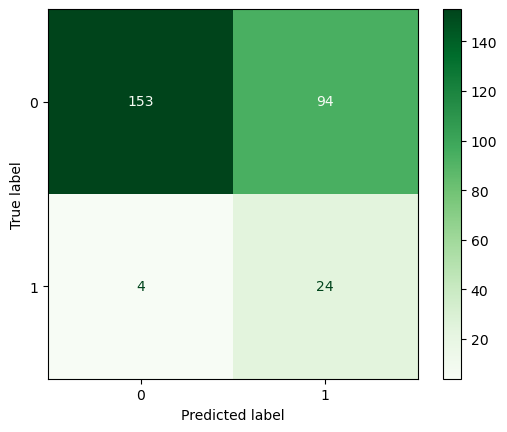

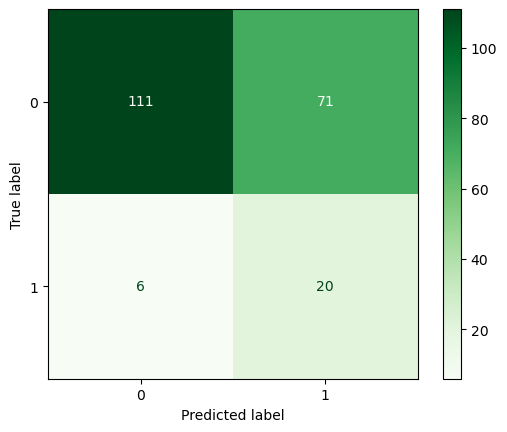

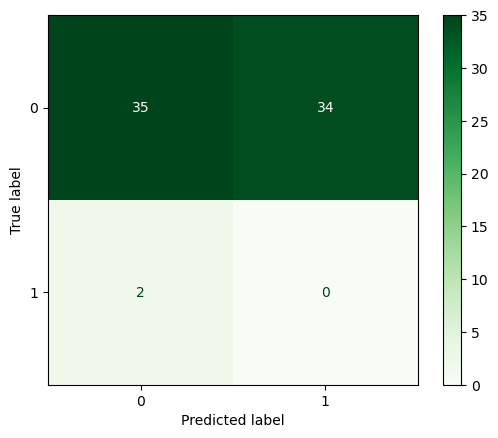

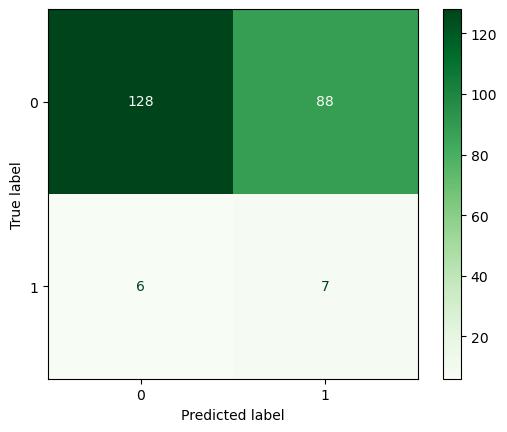

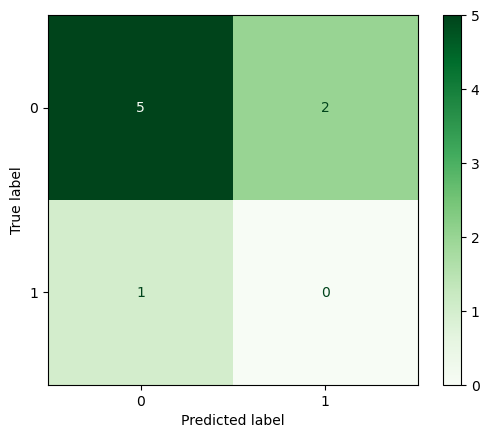

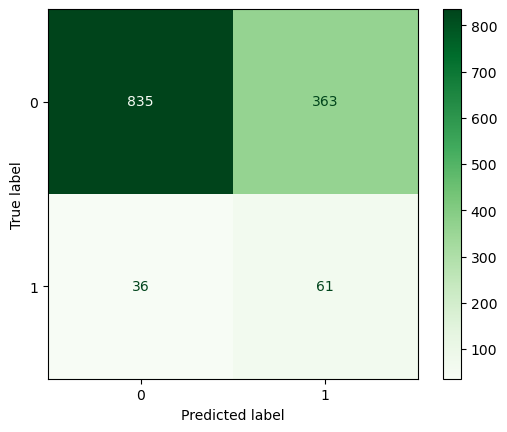

In [43]:
for r in races:
    race = r
    test_set = pd.concat([y_test,X_test],axis=1)
    group_test_set = test_set[test_set[race]==1]
    group_y_test = group_test_set[['PMAD']]
    idx = []
    for i in range(len(test_set)):
        if test_set[race].iloc[i]==1:
            idx.append(i)
    cm = confusion_matrix(group_y_test, y_pred_optim[idx])
    miss = np.round(100*cm[1][0]/sum(cm[1,:]),2)
    hit = np.round(100*cm[1][1]/sum(cm[1,:]),2)
    print(r,":",miss,"% miss rate")
    print(r,":",hit,"% hit rate")
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=plt.cm.Greens);

## 3.3. Neural Network

In [46]:
x = X_train_rus
y = y_train_rus.values.ravel()
w = weights_rus

nn = MLPClassifier(max_iter=1000, learning_rate_init=0.5)

seed(0)
parameter_space = {'hidden_layer_sizes': [(randint.rvs(1,15,1),randint.rvs(1,15,1),),(randint.rvs(1,15))],
                   'activation': ['tanh', 'relu', 'logistic'],
                   'solver': ['sgd', 'adam', 'lbfgs'],
                   'alpha': uniform(0.0001, 0.9, 3),
                   'learning_rate': ['constant','adaptive']}

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(nn, 
                                 param_distributions = parameter_space, 
                                 n_iter=5, 
                                 cv=5,
                                 verbose=1)

# Fit the random search object to the data
rand_search.fit(x, y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5,
                   estimator=MLPClassifier(learning_rate_init=0.5,
                                           max_iter=1000),
                   n_iter=5,
                   param_distributions={'activation': ['tanh', 'relu',
                                                       'logistic'],
                                        'alpha': array([0.54252676, 0.49044038, 0.38134695]),
                                        'hidden_layer_sizes': [(14, 7), 1],
                                        'learning_rate': ['constant',
                                                          'adaptive'],
                                        'solver': ['sgd', 'adam', 'lbfgs']},
                   verbose=1)

NN Best hyperparameters: {'solver': 'lbfgs', 'learning_rate': 'constant', 'hidden_layer_sizes': (14, 7), 'alpha': 0.5425267621268723, 'activation': 'logistic'}
Train Accuracy: 0.5
Train Balanced Acc: 0.5
Train AUC: 0.5
Train F1: 0.0
Train Confusion Matrix:
[[501   0]
 [501   0]]

Test Accuracy: 0.91994
Test Balanced Acc: 0.5
Test AUC: 0.5
Test F1: 0.0
Test Confusion Matrix:
[[1919    0]
 [ 167    0]]

---Optimum Threshold --- 0.05 --ROC-- 0.5
Optimal Test Accuracy: 0.08006
Optimal Test Balanced Accuracy: 0.5
Optimal Test AUC: 0.5
Test Confusion Matrix w/ Optimal Threshold:
[[   0 1919]
 [   0  167]]

Equalized odds difference w/ Optimal Threshold: 0.0
Equalized odds difference: 0.0


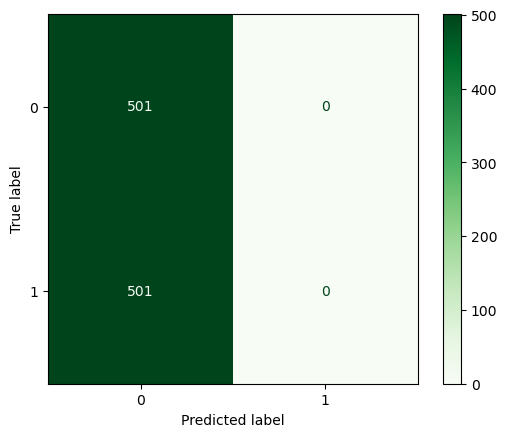

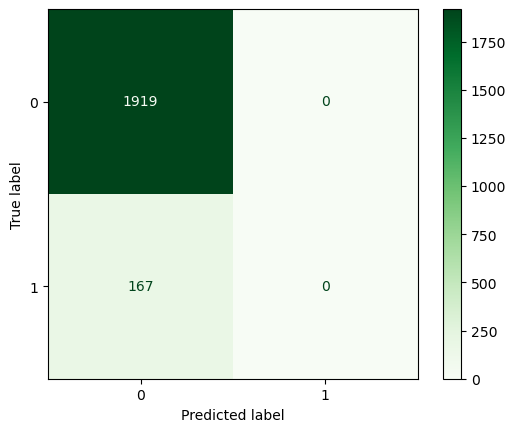

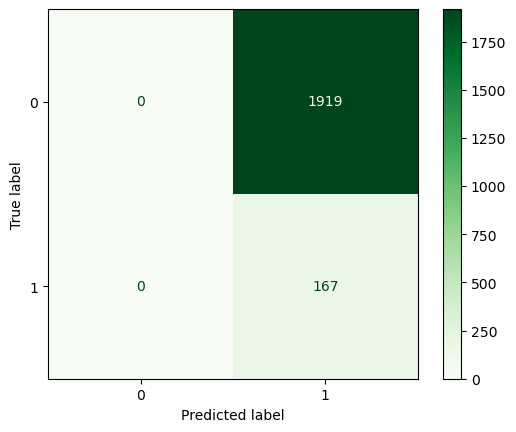

In [47]:
best_nn = rand_search.best_estimator_
print('NN Best hyperparameters:',  rand_search.best_params_)

display_performance(X_train=x, y_train=y, X_test=X_test, y_test=y_test, model=best_nn)

## 3.4. Gradient Boost

In [48]:
x = X_train_rus
y = y_train_rus.values.ravel()
w = weights_rus

gb = GradientBoostingClassifier()

seed(0)
parameter_space = {'n_estimators': randint(1,200),
                   'max_depth': randint(1,20),
                   'learning_rate': [uniform(0.000001,0.5),uniform(0.000001,1)],
                   'random_state': randint(0,50)}

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(gb, 
                                 param_distributions = parameter_space, 
                                 n_iter=5, 
                                 cv=5,
                                 verbose=1)

# Fit the random search object to the data

rand_search.fit(x, y, sample_weight=w)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_iter=5,
                   param_distributions={'learning_rate': [0.2744072031501585,
                                                          0.7151896511830531],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x15730e0d0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x15674d890>,
                                        'random_state': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x16a0faf90>},
                   verbose=1)

Gradient Boost Best hyperparameters: {'learning_rate': 0.7151896511830531, 'max_depth': 4, 'n_estimators': 104, 'random_state': 9}
Train Accuracy: 1.0
Train Balanced Acc: 1.0
Train AUC: 1.0
Train F1: 1.0
Train Confusion Matrix:
[[501   0]
 [  0 501]]

Test Accuracy: 0.60978
Test Balanced Acc: 0.61844
Test AUC: 0.61844
Test F1: 0.20508
Test Confusion Matrix:
[[1167  752]
 [  62  105]]

---Optimum Threshold --- 0.5 --ROC-- 0.61844
Optimal Test Accuracy: 0.60978
Optimal Test Balanced Accuracy: 0.61844
Optimal Test AUC: 0.61844
Test Confusion Matrix w/ Optimal Threshold:
[[1167  752]
 [  62  105]]

Equalized odds difference w/ Optimal Threshold: 0.86
Equalized odds difference: 0.86


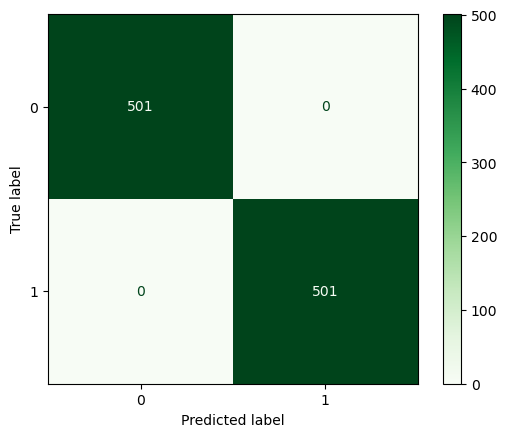

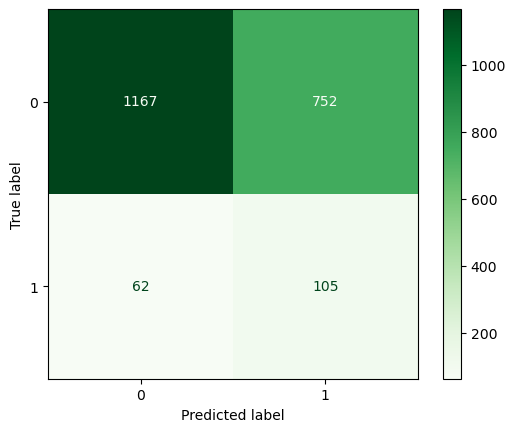

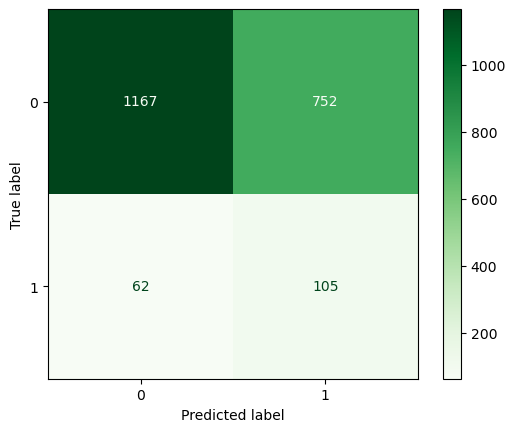

In [49]:
best_gb = rand_search.best_estimator_
print('Gradient Boost Best hyperparameters:',  rand_search.best_params_)

display_performance(X_train=x, y_train=y, X_test=X_test, y_test=y_test, model=best_gb)

In [53]:
races = ['MOM_RACE_Asian or Native Hawaiian or Other Pacific Islander',
         'MOM_RACE_Black or African American',
         'MOM_RACE_Multiracial',
         'MOM_RACE_Other',
         'MOM_RACE_Unknown',
         'MOM_RACE_White']

optim_thresh = 0.5
y_pred_optim = (best_gb.predict_proba(X_test)[:,1] >= optim_thresh).astype('int')
for r in races:
    feature = X_test[[r]]
    measure = np.round(equalized_odds_difference(y_test, y_pred_optim, sensitive_features=feature),5)
    print("Equalized odds difference:",r,":",measure)

Equalized odds difference: MOM_RACE_Asian or Native Hawaiian or Other Pacific Islander : 0.27441
Equalized odds difference: MOM_RACE_Black or African American : 0.11339
Equalized odds difference: MOM_RACE_Multiracial : 0.63636
Equalized odds difference: MOM_RACE_Other : 0.43157
Equalized odds difference: MOM_RACE_Unknown : 0.63253
Equalized odds difference: MOM_RACE_White : 0.08101


MOM_RACE_Asian or Native Hawaiian or Other Pacific Islander : 14.29 % miss rate
MOM_RACE_Asian or Native Hawaiian or Other Pacific Islander : 85.71 % hit rate
MOM_RACE_Black or African American : 38.46 % miss rate
MOM_RACE_Black or African American : 61.54 % hit rate
MOM_RACE_Multiracial : 100.0 % miss rate
MOM_RACE_Multiracial : 0.0 % hit rate
MOM_RACE_Other : 76.92 % miss rate
MOM_RACE_Other : 23.08 % hit rate
MOM_RACE_Unknown : 100.0 % miss rate
MOM_RACE_Unknown : 0.0 % hit rate
MOM_RACE_White : 36.08 % miss rate
MOM_RACE_White : 63.92 % hit rate


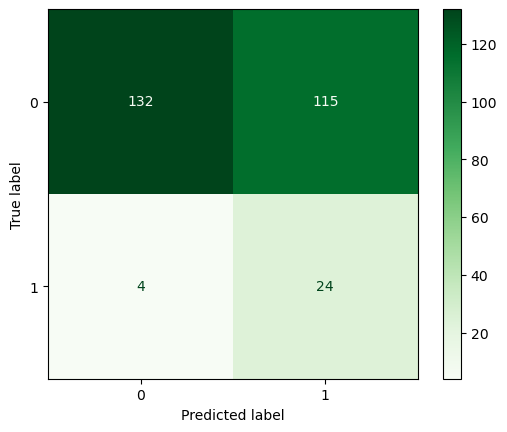

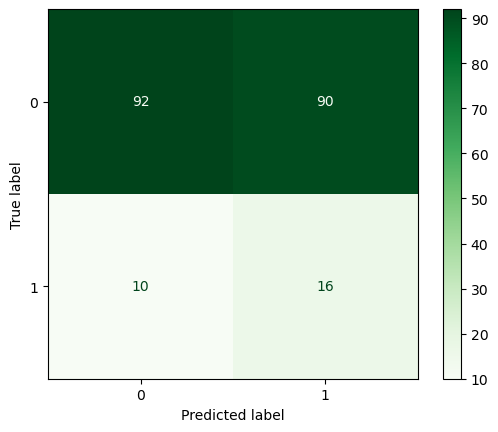

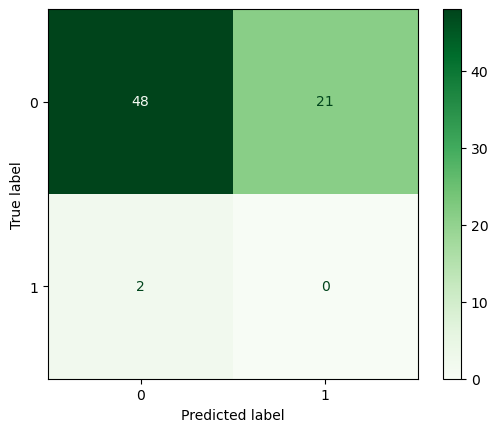

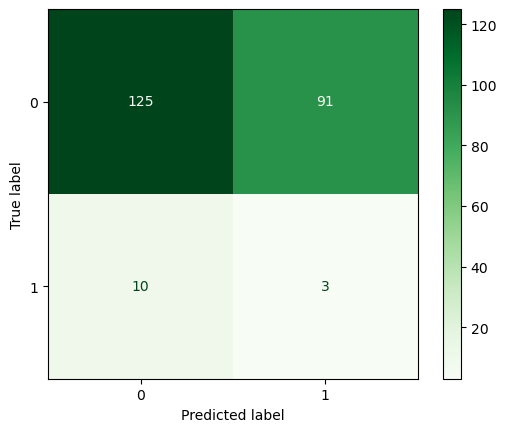

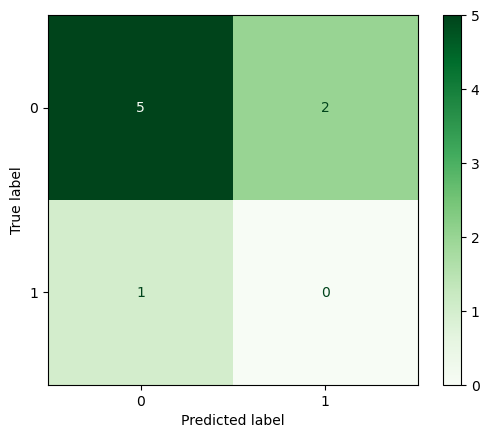

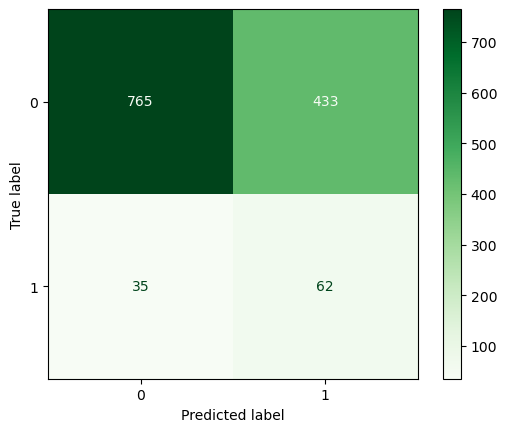

In [54]:
races = ['MOM_RACE_Asian or Native Hawaiian or Other Pacific Islander',
         'MOM_RACE_Black or African American',
         'MOM_RACE_Multiracial',
         'MOM_RACE_Other',
         'MOM_RACE_Unknown',
         'MOM_RACE_White']

for r in races:
    race = r
    test_set = pd.concat([y_test,X_test],axis=1)
    group_test_set = test_set[test_set[race]==1]
    group_y_test = group_test_set[['PMAD']]
    idx = []
    for i in range(len(test_set)):
        if test_set[race].iloc[i]==1:
            idx.append(i)
    cm = confusion_matrix(group_y_test, y_pred_optim[idx])
    miss = np.round(100*cm[1][0]/sum(cm[1,:]),2)
    hit = np.round(100*cm[1][1]/sum(cm[1,:]),2)
    print(r,":",miss,"% miss rate")
    print(r,":",hit,"% hit rate")
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=plt.cm.Greens);

## 3.5. Support Vector Machine

In [55]:
x = X_train_rus
y = y_train_rus.values.ravel()
w = weights_rus

support_vec = svm.SVC(kernel='rbf', C=100, class_weight={0:1,1:1}, random_state=0)
support_vec.fit(x, y, sample_weight=w)

SVC(C=100, class_weight={0: 1, 1: 1}, random_state=0)

Train Accuracy: 0.54291
Train Balanced Acc: 0.54291
Train AUC: 0.54291
Train F1: 0.36034
Train Confusion Matrix:
[[415  86]
 [372 129]]

Test Accuracy: 0.74353
Test Balanced Acc: 0.49979
Test AUC: 0.49979
Test F1: 0.1157
Test Confusion Matrix:
[[1516  403]
 [ 132   35]]



AttributeError: predict_proba is not available when probability=False

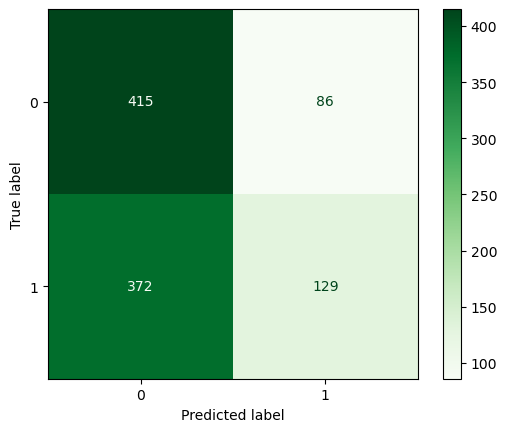

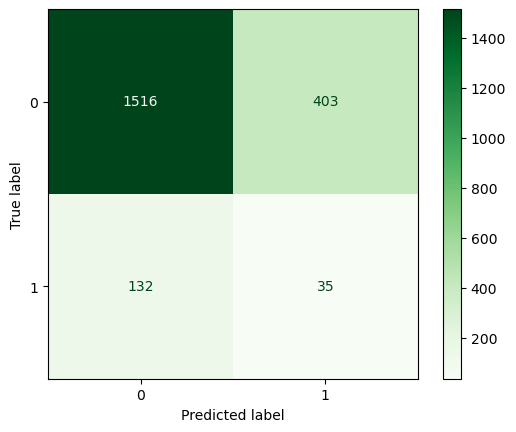

In [56]:
display_performance(X_train=x, y_train=y, X_test=X_test, y_test=y_test, model=support_vec)

### Finetune SVC through Randomized Search

In [ ]:
x = X_train_rus
y = y_train_rus.values.ravel()
w = weights_rus

support_vec = svm.SVC(class_weight = {0:0.1, 1:0.9})

seed(0)
parameter_space = {'C': [0.5,1,1.5,2,2.5,3],
                   'kernel': ['rbf','linear', 'poly', 'sigmoid'],
                   'degree': [1,2,3,4,5],
                   'gamma': ['scale','auto'],
                   'random_state': randint(0,50)}

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(support_vec, 
                                 param_distributions = parameter_space, 
                                 n_iter=5, 
                                 cv=5,
                                 verbose=1)

# Fit the random search object to the data
rand_search.fit(x, y, sample_weight=w)

In [ ]:
best_support_vec = rand_search.best_estimator_
print('SVM Best hyperparameters:',  rand_search.best_params_)

display_performance(X_train=x, y_train=y, X_test=X_test, y_test=y_test, model=best_support_vec)

## 3.6. Naive Bayes Classifier

Train Accuracy: 0.63273
Train Balanced Acc: 0.63273
Train AUC: 0.63273
Train F1: 0.64341
Train Confusion Matrix:
[[302 199]
 [169 332]]

Test Accuracy: 0.61361
Test Balanced Acc: 0.64785
Test AUC: 0.64785
Test F1: 0.22201
Test Confusion Matrix:
[[1165  754]
 [  52  115]]

---Optimum Threshold --- 0.75 --ROC-- 0.65831
Optimal Test Accuracy: 0.71333
Optimal Test Balanced Accuracy: 0.65831
Optimal Test AUC: 0.65831
Test Confusion Matrix w/ Optimal Threshold:
[[1389  530]
 [  68   99]]

Equalized odds difference w/ Optimal Threshold: 1.0
Equalized odds difference: 1.0


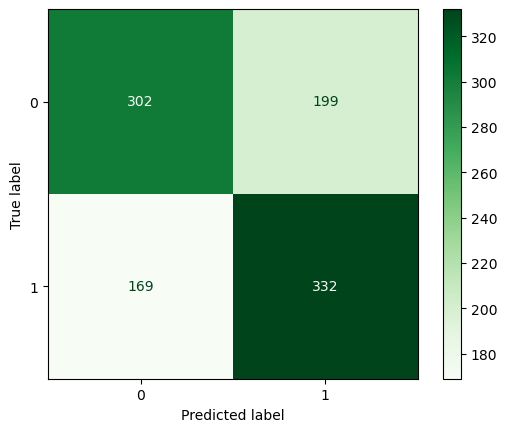

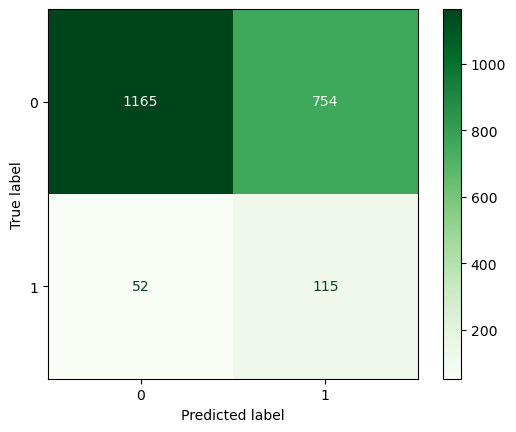

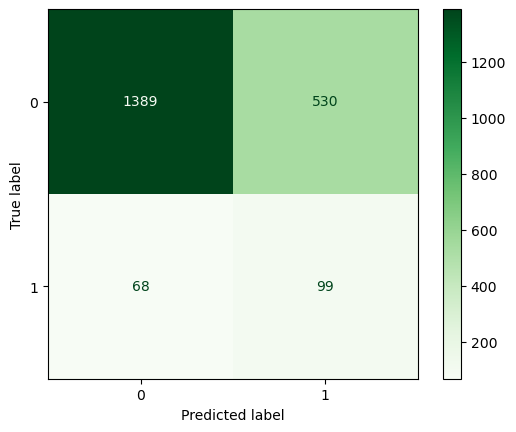

In [57]:
x = X_train_rus
y = y_train_rus.values.ravel()
w = weights_rus

gnb = GaussianNB()
gnb.fit(x,y,sample_weight=2)

display_performance(X_train=x, y_train=y, X_test=X_test, y_test=y_test, model=gnb)

## 3.7. TPOT2

In [ ]:
if __name__=="__main__":
    
    # Get a scorer from string.
    # scoring = method as string (e.g., 'roc_auc_ovr'.
    scorer = sklearn.metrics.get_scorer('roc_auc_ovr')
    #scorer = sklearn.metrics.roc_auc_score(multi_class='ovr')
    
    # Split arrays or matrices into random train and test subsets.
    #X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25, shuffle=True)
    
    
    # scorers can be a list of strings or a list of scorers. These get evaluated during cross validation. 
    est = tpot2.TPOTEstimatorSteadyState( 
                            scorers=['roc_auc_ovr'], #scorers can be a list of strings or a list of scorers. These get evaluated during cross validation. 
                            scorers_weights=[1],
                            classification=True,
                            max_eval_time_seconds=15,
                            max_time_seconds=30,
                            verbose=2)
    
    # Fits the above TPOT model to the training set.
    est.fit(X_train, y_train.values.ravel())
    
    y_pred = est.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    print("TPOT2 Test Accuracy:", np.round(test_accuracy,2))

    
    # Get the cross validated roc_auc_ovr on test sets.
    #print("roc_auc_ovo:",scorer(est, X_test, y_test))
    print("roc_auc_ovr:",scorer(est, X_test, y_test))
    
    
    fitted_pipeline = est.fitted_pipeline_ # access best pipeline directly
    fitted_pipeline.plot() #plot the best pipeline
    
    # Fairness metrics
    print("Demographic parity difference:",np.round(demographic_parity_difference(y_test, y_pred,sensitive_features=race_feature),2))
    #print("Demographic parity ratio:",np.round(demographic_parity_ratio(y_test, y_pred,sensitive_features=race_feature),2))
    #print("Equalized odds difference:",np.round(equalized_odds_difference(y_test, y_pred,sensitive_features=race_feature),2))
    #print("Equalized odds ratio:",np.round(equalized_odds_ratio(y_test, y_pred,sensitive_features=race_feature),2))


    # Create the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("TPOT2 Confusion Matrix:")
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=plt.cm.Greens);

In [ ]:
# save this file and output as html
import os
os.system('jupyter nbconvert --to html data_analysis.ipynb')